In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import transformers
import seaborn as sns
import numpy as np

from transformers import AutoTokenizer, AutoModel, AutoConfig, DataCollatorWithPadding
from datasets import load_dataset
from torch.utils.data import DataLoader

In [86]:
pd.set_option('display.max_colwidth', None)

# Sentiment Analysis using emotion dataset

## Load the data and take a look at it

In [2]:
emotions_ds = load_dataset("emotion")

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/Users/davidbreinl/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
emotions_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
class_names = emotions_ds["train"].features["label"].names
class_names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [5]:
emotions_ds.set_format("pandas")

In [6]:
emotions_ds_train_pandas = emotions_ds["train"][:]

In [7]:
emotions_ds_train_pandas

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


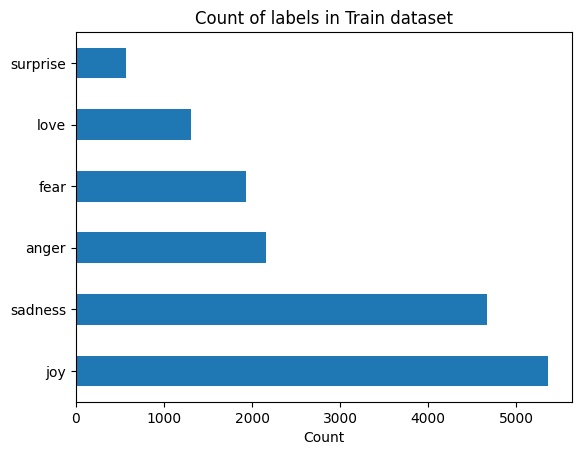

In [8]:
# As we can see we are dealing with an imbalanced dataset -> we need to take this into account when training our model (Accuracy probably not a good metric)

emotions_ds_train_pandas["label_names"] = [class_names[idx] for idx in emotions_ds["train"][:]["label"]]
emotions_ds_train_pandas["label_names"].value_counts().plot.barh()
plt.title("Count of labels in Train dataset")
plt.xlabel("Count")
plt.show()

In [9]:
emotions_ds_train_pandas["text"][0].split(" ")

['i', 'didnt', 'feel', 'humiliated']

In [10]:
emotions_ds_train_pandas["tweet_word_count"] = [len(tweet.split(" ")) for tweet in emotions_ds_train_pandas["text"]]

<AxesSubplot: xlabel='label_names', ylabel='tweet_word_count'>

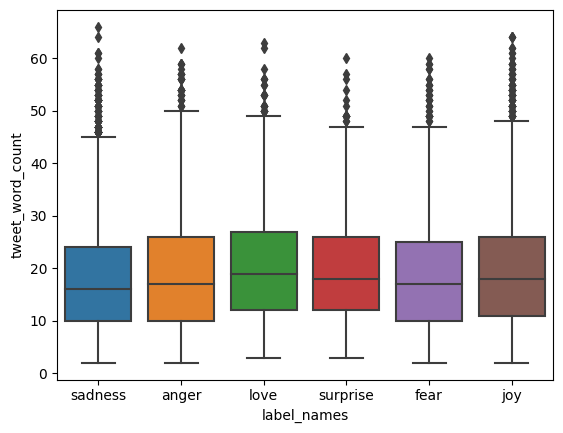

In [11]:
sns.boxplot(x="label_names", y="tweet_word_count", data=emotions_ds_train_pandas)

## Creating baseline without solving class imbalence problem

### Lets Encode the data

In [12]:
emotions_ds.reset_format()

In [13]:
MODEL_CHKPT = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHKPT)

tokenizer("this is a test in order to see if the encoder is working", return_tensors="pt")

{'input_ids': tensor([[  101,  2023,  2003,  1037,  3231,  1999,  2344,  2000,  2156,  2065,
          1996,  4372, 16044,  2099,  2003,  2551,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [14]:
# We first have to define a function that we can then apply onto our entire huggingface dataset
def tokenize_batch(batch):
    return tokenizer(batch["text"], 
                     padding=True,
                     truncation=True,
                     add_special_tokens=True,
                     return_tensors="pt")

# Lets check if the function is actually working
tokenize_batch(emotions_ds["train"][:2])

{'input_ids': tensor([[  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101,  1045,  2064,  2175,  2013,  3110,  2061, 20625,  2000,  2061,
          9636, 17772,  2074,  2013,  2108,  2105,  2619,  2040, 14977,  1998,
          2003,  8300,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [15]:
tweets_encoded = emotions_ds.map(tokenize_batch, batched=True, batch_size=None) #batch_size NONE!!!!!!!! Very important since else our tokens are in different lengths
tweets_encoded # as we can see we now included the input ids and the attention mask

Loading cached processed dataset at /Users/davidbreinl/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-adf5e58498032292.arrow
Loading cached processed dataset at /Users/davidbreinl/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-5c21202645d89d6a.arrow
Loading cached processed dataset at /Users/davidbreinl/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-918c84ec8ab24327.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [16]:
# We can see that all of our input_ids in the training set have the same length -> thats what we want
set([len(item) for item in tweets_encoded["train"]["input_ids"]])

{87}

In [17]:
# since our pytorch model will expect us to input torch tensors lets switch the format
tweets_encoded.set_format("torch",
                          columns=["input_ids", "attention_mask", "label"])

In [18]:
# Lets take a look at the first two examples
tweets_encoded["train"][:2]

{'label': tensor([0, 0]),
 'input_ids': tensor([[  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0],
         [  101,  1045,  2064,  2175,  2013,  3110,  2061, 20625,  2000,  2061,
           9636, 17772,  2074,  2013,  2108,  2105,  2619,  2040, 14977,  1998,
           2003,  8300,   102,     0,     0,     0,     0,     0,     0,     0,
              0,     

In [19]:
# Define a datacollator that will assist us in stacking out tensors and making sure that each batch gets padded to the maximum length
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Define Dataloaders for our PyTorch Model

In [20]:
BATCH_SIZE=32

train_dataloader= DataLoader(tweets_encoded["train"], batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)
val_dataloader= DataLoader(tweets_encoded["validation"], batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)

In [21]:
# Lets check if the dataloaders are ready to go
train_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fb008a53fa0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fb008a52fb0>)

In [22]:
# Lets check out the first batch inside of our train_dataloader
next(iter(train_dataloader))

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': tensor([[  101, 10047,  2074,  ...,     0,     0,     0],
        [  101,  1045,  2113,  ...,     0,     0,     0],
        [  101,  1045,  5225,  ...,     0,     0,     0],
        ...,
        [  101,  1045,  2097,  ...,     0,     0,     0],
        [  101,  1045,  2514,  ...,     0,     0,     0],
        [  101,  1045,  5630,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([3, 1, 0, 3, 0, 0, 1, 0, 4, 1, 5, 0, 1, 0, 3, 4, 2, 1, 4, 0, 2, 2, 3, 0,
        1, 1, 0, 0, 4, 2, 0, 0])}

### Lets now train our finetuned baseline model

In [23]:
from modeling.model import TweetClassificationModel
from modeling.train import Model_training
import torch
from transformers import get_scheduler
from modeling.model_utils import EarlyStopper

In [24]:
model = AutoModel.from_pretrained(MODEL_CHKPT)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
AutoConfig.from_pretrained(MODEL_CHKPT)

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.27.3",
  "vocab_size": 30522
}

In [26]:
# Lets now import our custom finetunded model
model = TweetClassificationModel(checkpoint=MODEL_CHKPT, num_classes=len(class_names))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
# Lets also use our custom trainer class
trainer = Model_training(model=model, device=torch.device("mps"))

In [28]:
early_stopper = EarlyStopper(patience=0)
optimizer=torch.optim.AdamW(model.parameters(), lr=1e-5)

In [29]:
torch.manual_seed(42)

results = trainer.train(train_dataloader=train_dataloader,
              eval_dataloader=val_dataloader,
              optimizer=optimizer,
              epochs=5,
              early_stopper=early_stopper,
              model_save_name="distilbert-base-finetuned-for-tweet-classification"
              )

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1, Current LR: 1e-05:
Train Loss: 0.70193 | Train F1: 0.70908 | Train Acc: 0.74562
Validation Loss: 0.27287 | Validation F1: 0.90013 | Validation Acc: 0.90278



 20%|██        | 1/5 [04:04<16:17, 244.44s/it]

Epoch 2, Current LR: 1e-05:
Train Loss: 0.18720 | Train F1: 0.92461 | Train Acc: 0.92594
Validation Loss: 0.18010 | Validation F1: 0.92642 | Validation Acc: 0.92460



 40%|████      | 2/5 [08:07<12:11, 243.69s/it]

Epoch 3, Current LR: 1e-05:
Train Loss: 0.12678 | Train F1: 0.94509 | Train Acc: 0.94575
Validation Loss: 0.16631 | Validation F1: 0.92570 | Validation Acc: 0.92560



 60%|██████    | 3/5 [12:10<08:06, 243.16s/it]

Epoch 4, Current LR: 1e-05:
Train Loss: 0.10335 | Train F1: 0.95247 | Train Acc: 0.95263
Validation Loss: 0.15643 | Validation F1: 0.93451 | Validation Acc: 0.93601



 80%|████████  | 4/5 [20:11<05:02, 302.97s/it]

Epoch 5, Current LR: 1e-05:
Train Loss: 0.08946 | Train F1: 0.95945 | Train Acc: 0.95956
Validation Loss: 0.16327 | Validation F1: 0.93266 | Validation Acc: 0.93204

Stopping Training..


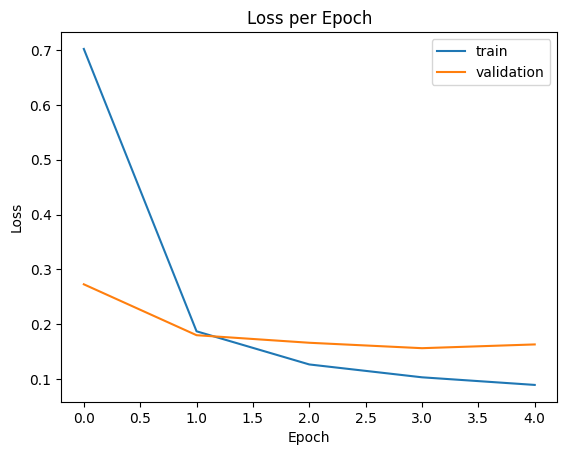

In [104]:
plt.plot(results["train_loss"],label="train")
plt.plot(results["val_loss"],label="validation")
plt.legend()
plt.title("Loss per Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

### Evaluate the baseline model

In [33]:
from modeling.model import TweetClassificationModel

In [36]:
trained_model = TweetClassificationModel(MODEL_CHKPT, len(class_names))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
trained_model.load_state_dict(torch.load("modeling/models/distilbert-base-finetuned-for-tweet-classification.pth"))

<All keys matched successfully>

In [44]:
trained_model = trained_model.to(torch.device("mps"))

In [45]:
from torch import nn
from torch.nn.functional import cross_entropy

In [49]:
def forward_pass_with_label(batch):
    with torch.inference_mode():

        inputs = {k:v.to(torch.device("mps")) for k,v in batch.items() if k in tokenizer.model_input_names}

        output = trained_model(input_ids = inputs["input_ids"],
                       attention_mask = inputs["attention_mask"],
                       labels=None)

        pred_label = torch.argmax(output["logits"], dim=1)

        loss = cross_entropy(input=output.logits, target=batch["label"].to(torch.device("mps")), reduction="none")

    return {
        "loss": loss.cpu().numpy(),
        "predicted_label": pred_label.cpu().numpy()
    }

In [50]:
tweets_encoded["test"] = tweets_encoded["test"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [51]:
tweets_encoded.set_format("pandas")

In [90]:
# Lets look at the texts with the largest losses -> model had the hardest time predicting

loss_df = tweets_encoded["test"][:][["text", "label",  "loss", "predicted_label"]]
loss_df["true_label"] = [class_names[sentiment] for sentiment in loss_df["label"]]
loss_df["predicted_label"] = [class_names[sentiment] for sentiment in loss_df["predicted_label"]]

In [91]:
loss_df.sort_values("loss", ascending=False).head(30)

,text,label,loss,predicted_label,true_label
816,whenever i put myself in others shoes and try to make the person happy,3,7.373516,joy,anger
1382,i cannot even begin to express in words the depth of sorrow that i feel having not posted any of my ludicrous rants over the passed days,5,6.865073,sadness,surprise
150,im feeling rather angsty and listless,0,6.349593,love,sadness
125,i feel very mislead by someone that i really really thought i knew and liked very much so,2,6.225420,anger,love
1613,i feel very cheated since i am supporting the family and doing all the other stuff while he spends hours a day gaming,1,5.950356,sadness,joy
1928,i feel inside cause life is like a game sometimes but then you came around me the walls just disappeared nothing to surround me and keep me from my fears im unprotected see how ive opened up youve made me trust,4,5.477125,sadness,fear
1253,i don t feel betrayed coz the backstabber had no grounds for their accusation but i m just amazed at some people s ability to do such things,5,4.474851,sadness,surprise
1533,i actually was in a meeting last week where someone yelled at an older lady because her phone rang i felt terrible for her your boss treats you unfairly or in this case someone makes you feel you are not worth anything is only allowing those who offended to steal your joy,3,4.302269,sadness,anger
290,i just feel are ludicrous and wasting space or so trite they should have looked at the book first and come up with something a little more original,5,4.026537,sadness,surprise
426,i feel unprotected a class post count link href http reprogramming in process,0,3.768774,fear,sadness


In [56]:
# Lets create a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.show()

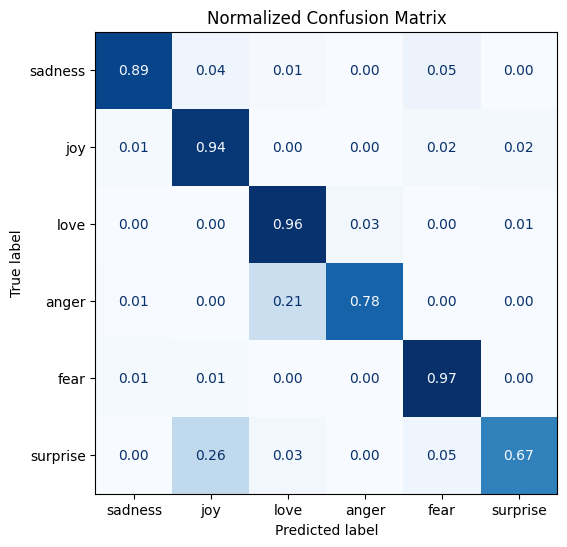

In [57]:
plot_confusion_matrix(loss_df["predicted_label"], loss_df["sentiment"], labels=class_names)

### Make some predictions on custom text

In [67]:
from modeling.inference import make_predictions


In [78]:
text = "It's really cool that I am now able to classify some tweets"

make_predictions(text, class_names, tokenizer, trained_model)

'joy'